## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')


In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)

## 1 - Load and prepare the training dataset

In [7]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

pyLDAvis.enable_notebook()

In [8]:
# Load the variables dictionary and return the features list
varaibles_path = os.path.join(cleaned_data_path, 'variables.json')
features = build_features.load_features(varaibles_path)

# Load and clean the REASON FOR VISIT classification summary of codes
rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
rfv_df = build_features.load_rfv(rfv_path)

# Load the list of three-digit categories of ICD-9-CM
icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
icd9cm_df = build_features.load_icd9cm(icd9cm_path)

icd9cm_category = 'CATEGORY_1'

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 36


c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\pack

In [9]:
# Define the function to load and prepare the data
def prepare_data(df, df_type, features, rfv_df, icd9cm_df, icd9cm_category, figure_path):
    df = build_features.build_features(df, rfv_df, icd9cm_df, category=icd9cm_category)

    # Drop the rows from with NA in 'DIAG1_CAT'
    non_missing_mask = df['DIAG1_CAT'].notna()
    procd_df = df.loc[
        non_missing_mask,
        ['DIAG1_CAT'] + features + [
            'RFV1_MOD1', 'RFV1_MOD2', 'RFV2_MOD1', 'RFV2_MOD2', 'RFV3_MOD1', 'RFV3_MOD2',
            'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
        ]
    ].copy()
    print(f'Number of available dependent samples: {non_missing_mask.sum()}')
    print()

    # Combine and preprocess textual features
    procd_df['TEXT'] = procd_df.apply(lambda x: build_features.combine_textual(x, features), axis=1)

    # Add in sentence embeddings using BERT and pre-trained BiomedBERT model
    #procd_df = build_features.generate_embeddings(procd_df)

    # Add in topic feature (topic probabilities) using LDA
    procd_df, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
        procd_df, n_topics=10, n_top_words=10, transform='log'
    )

    # Visualize the topics with pyLDAvis
    lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
    pyLDAvis.save_html(lda_vis, os.path.join(figure_path, f'{df_type}_lda_vis.html'))
    pyLDAvis.save_json(lda_vis, os.path.join(report_path, f'{df_type}_lda_vis.json'))

    # Plot the heat map of topic distributions among the labels in the dataset with Altair
    topic_df = procd_df[['DIAG1_CAT'] + topic_features].melt(id_vars='DIAG1_CAT', var_name='Topic', value_name='Probability')

    chart(
        df=topic_df,
        y='DIAG1_CAT:N',
        x='Topic:N',
        color='Probability:Q',
        title=f'Distribution of the Labels in the {df_type} Dataset',
    ).mark_rect().configure_axisY(
        labelLimit=500, title=None
    ).configure_axisX(
        labelAngle=45,
        title=None
    ).properties(width=300, height=500).save(os.path.join(figure_path, f'{df_type}_topic_distribution_heatmap.png'), ppi=300)

    # Plot the distribution and percentage of true labels
    chart(
        df=procd_df['DIAG1_CAT'].value_counts(normalize=True).reset_index(),
        x='DIAG1_CAT:N',
        y='proportion:Q',
        title=f'Distribution of the Labels in the {df_type} Dataset',
    ).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None).save(os.path.join(figure_path, f'{df_type}_label_distribution.png'), ppi=300)
    
    return procd_df

### 1.1 - Load the training dataset

In [10]:
procd_train_path = os.path.join(processed_data_path, 'procd_train.parquet')

if os.path.exists(procd_train_path):
    procd_train = pd.read_parquet(procd_train_path)
else:
    # Load the training dataset
    train_df = pd.read_parquet(os.path.join(cleaned_data_path, 'train.parquet'))

    procd_train = prepare_data(train_df, 'train', features, rfv_df, icd9cm_df, icd9cm_category, figure_path)
    procd_train.to_parquet(procd_train_path)

In [11]:
# Define the X_train and y_train
X_train = procd_train.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_train['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (78946, 58)
y Shape: (78946,)


### 1.2 - Check the topic and the label distributions

In [12]:
def prepared_data_from_dict(vis_data):
    # Code adapted from https://github.com/bmabey/pyLDAvis/issues/134
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)


# Load and display the pyLDAvis from saved json file
with open(os.path.join(report_path, 'train_lda_vis.json'), 'r') as f:
    lda_vis = json.load(f)

# Display the pyLDAvis from saved json file
prepared_data = prepared_data_from_dict(lda_vis)
pyLDAvis.display(prepared_data)

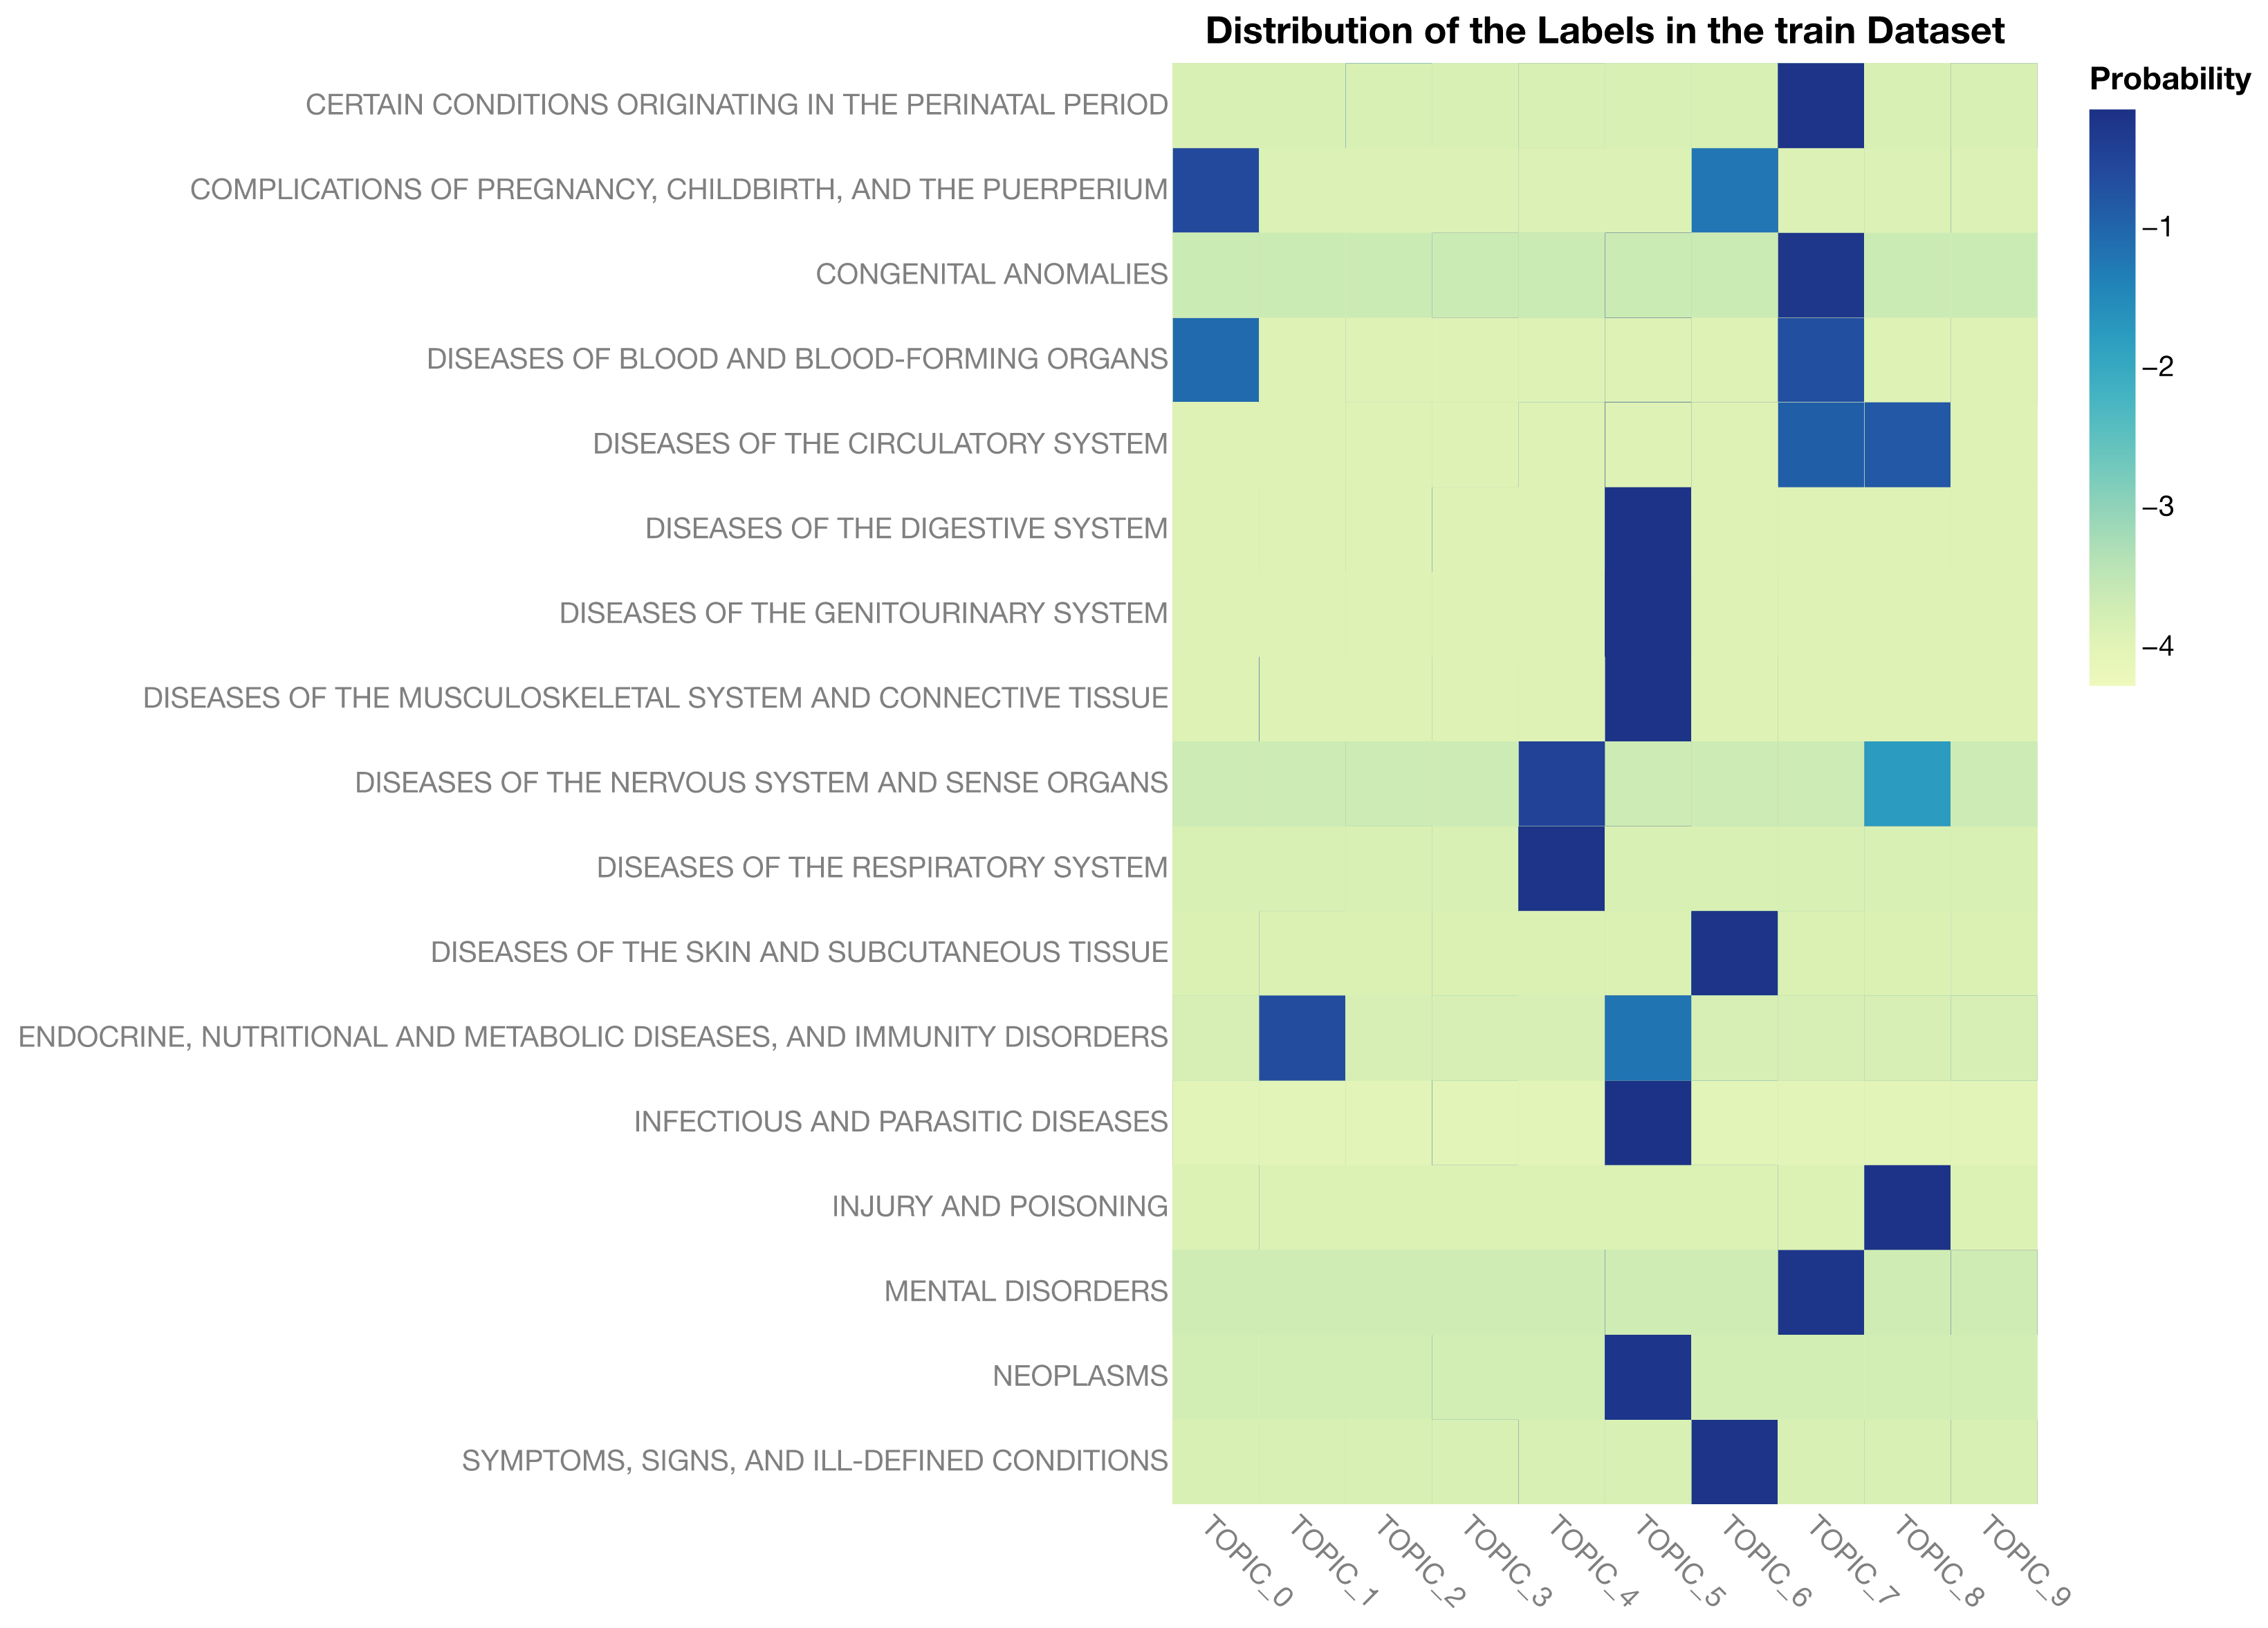

In [13]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'train_topic_distribution_heatmap.png'))

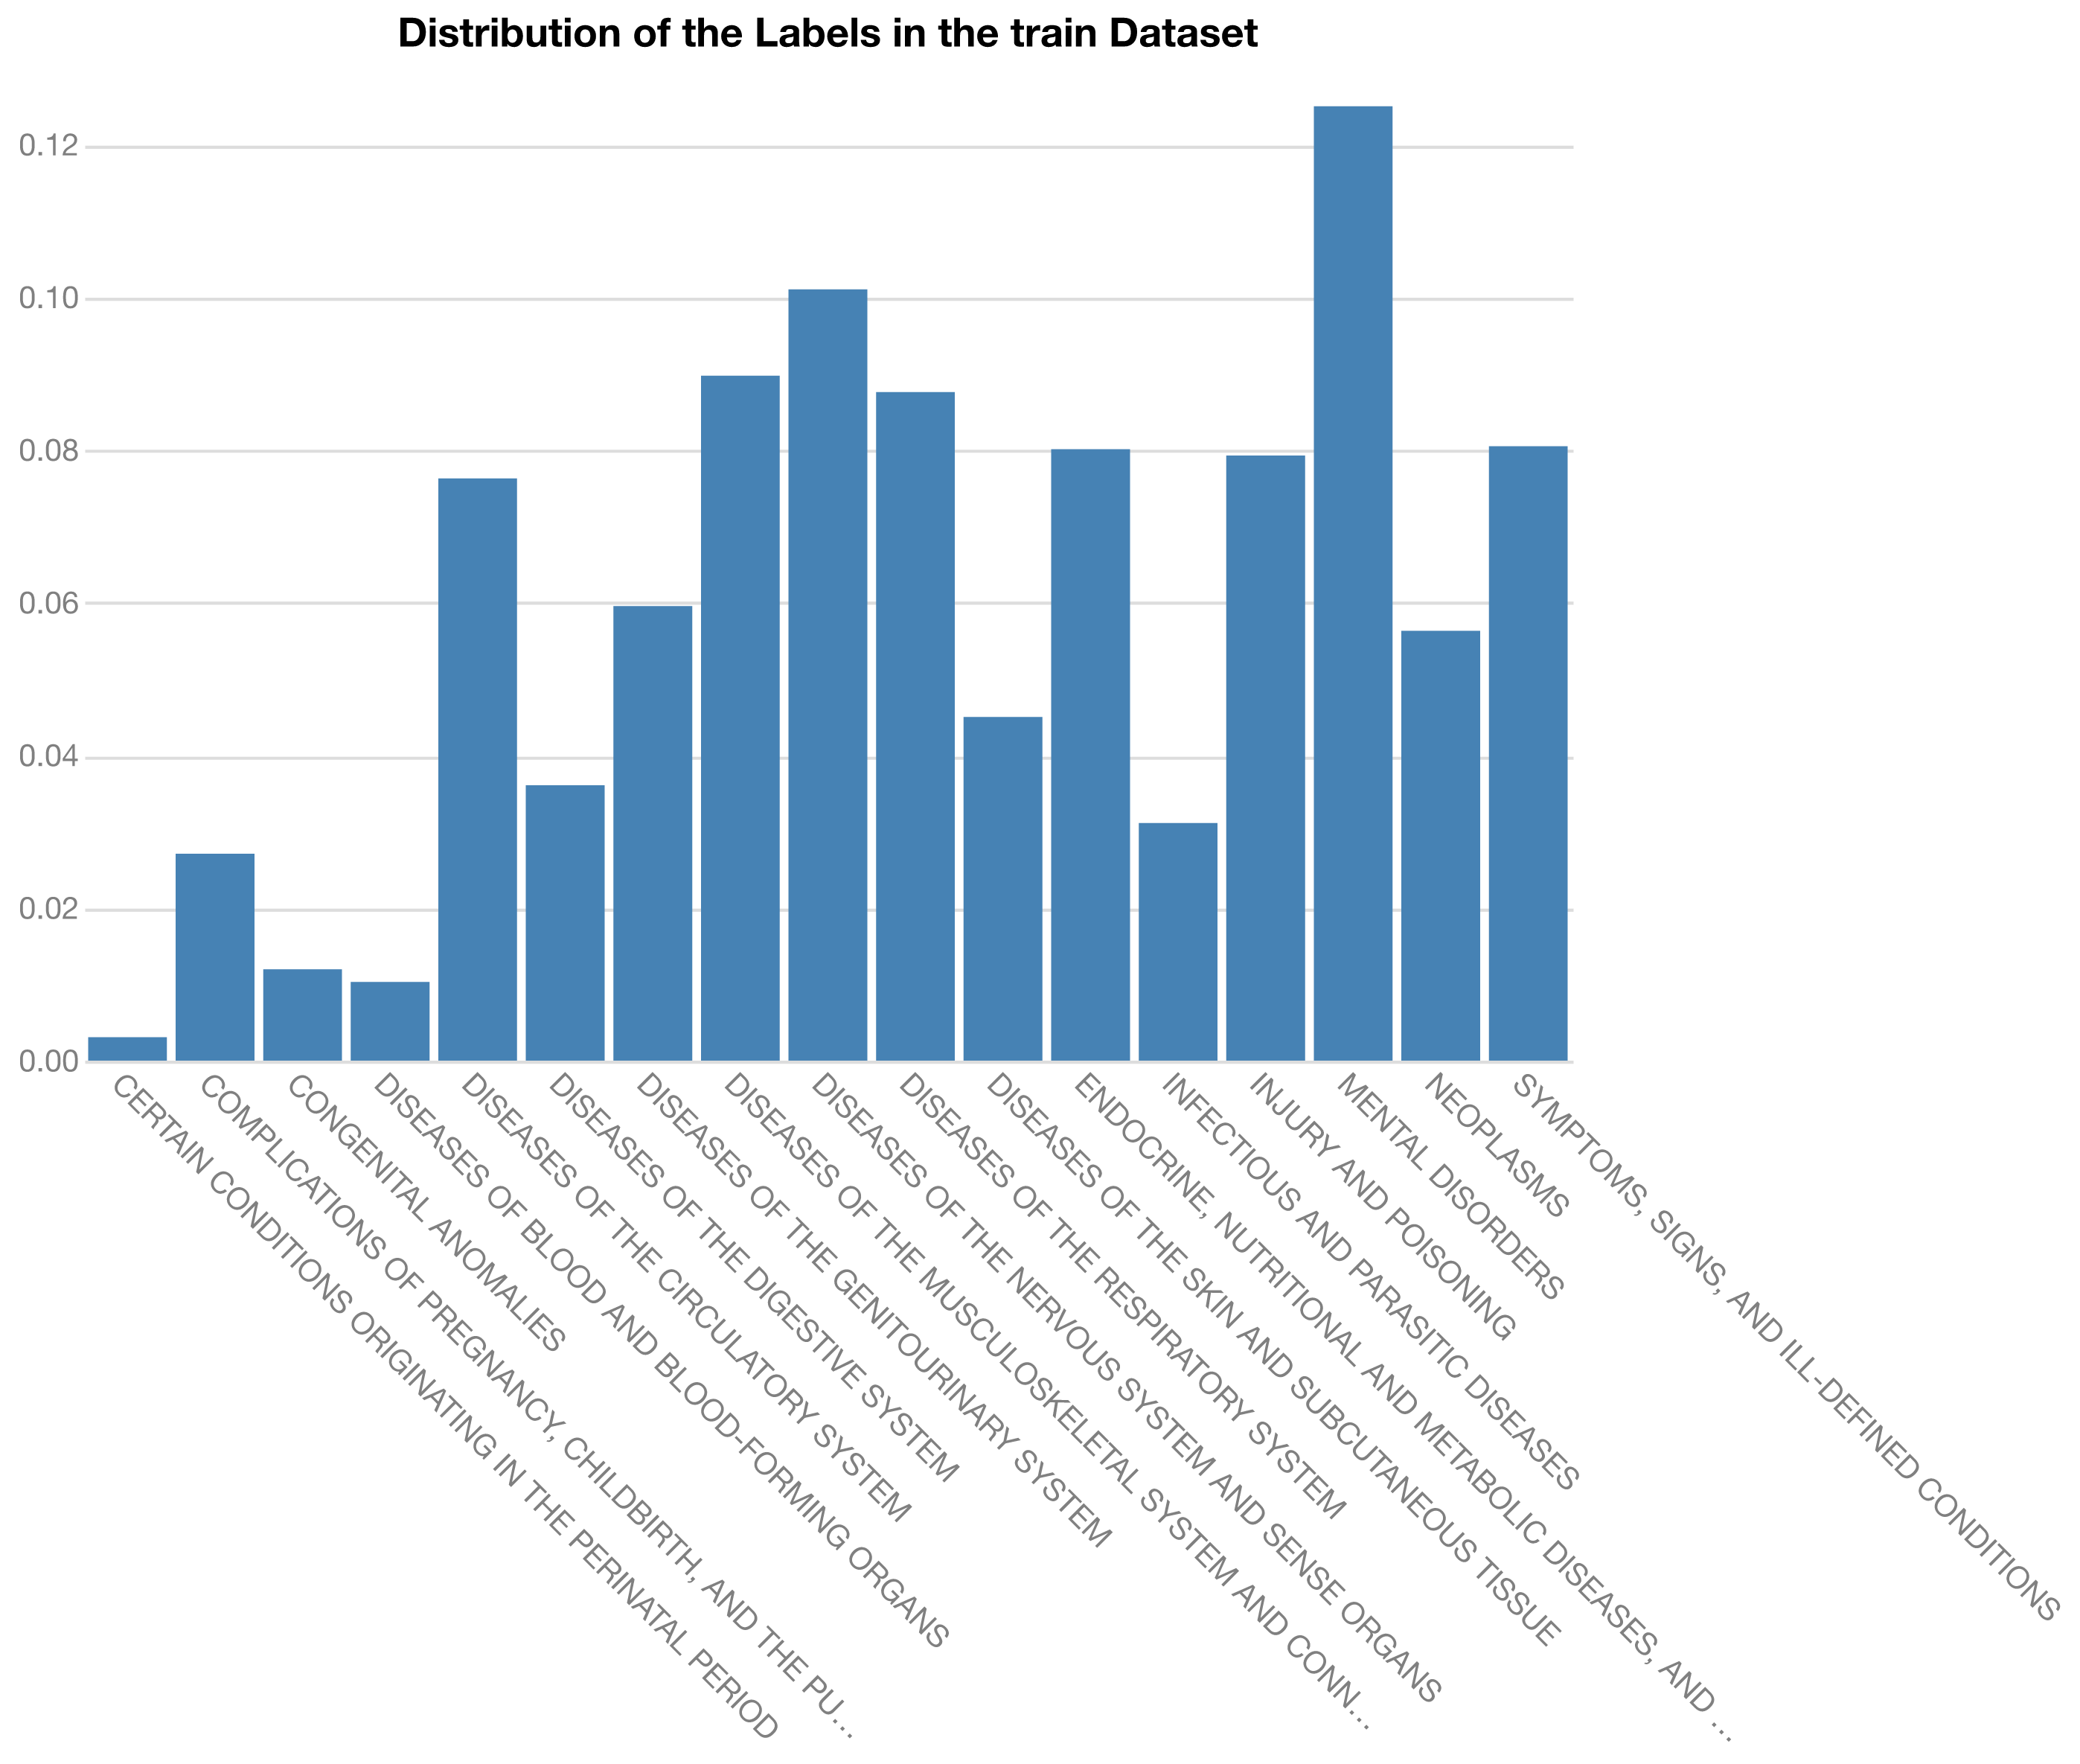

In [14]:
# Load and display the distribution and percentage of the labels
from IPython.display import display
display(Image(filename=os.path.join(figure_path, 'train_label_distribution.png')))

## 2 - Load and prepare the validation dataset

### 2.1 - Load the validation dataset

In [15]:
procd_val_path = os.path.join(processed_data_path, 'procd_val.parquet')

if os.path.exists(procd_val_path):
    procd_val = pd.read_parquet(procd_val_path)
else:
    # Load the validation dataset
    val_df = pd.read_parquet(os.path.join(cleaned_data_path, 'val.parquet'))

    procd_val = prepare_data(val_df, 'val', features, rfv_df, icd9cm_df, icd9cm_category, figure_path)
    procd_val.to_parquet(procd_val_path)

In [16]:
# Define the X_val and y_val
X_val = procd_val.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_val = procd_val['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (78946, 58)
y Shape: (78946,)


## 3 - Grid Search

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

random_state = 42

### 3.1 - Define the pipeline

In [18]:
# Set up the pipeline

class OptionalPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        if self.n_components is not None:
            self.pca.fit(X)
        return self
    
    def transform(self, X):
        if self.n_components is not None:
            return self.pca.transform(X)
        return X


def set_pipeline(model, binary_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5, ovr=False):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
        ],
        remainder='passthrough',
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    if ovr:
        model = OneVsRestClassifier(model)
    
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('pca', OptionalPCA()),
        ('classifier', model),
    ]
    
    #if pca is not None:
    #    steps.insert(-1, ('pca', PCA(n_components=pca)))

    pipeline = Pipeline(steps)

    return pipeline

### 3.2 - Define the feature sets

In [19]:
# Define the feature sets
# With original quantitative data and RFV codes + RFV Modules + Topic Features
binary_features = [
    'SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS'
]
quantitative_features = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']
topic_features = [col for col in X_train.columns if col.startswith('TOPIC')]

clf_features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[clf_features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[clf_features].shape}')
print(f'Features to be fit: \n{X_train[clf_features].columns}')

Missing Values in X_train: 
PASTVIS       15702.0
HTIN          44208.0
WTLB          27592.0
BMI           48130.0
TEMPF         41616.0
BPSYS         31244.0
BPDIAS        31342.0
RFV1_TEXT       971.0
RFV2_TEXT     48999.0
RFV3_TEXT     67936.0
DIAG2_TEXT    36722.0
DIAG3_TEXT    58663.0
dtype: float64

Shape of X_train: (78946, 45)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')


### 3.3 - HalvingGridSearchCV

In [ ]:
# Set up a HalvingGridSearchCV

# Define the parameter grid for random forest classifier
param_grid = {
    'classifier__n_estimators': [100, 500, 1000],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'classifier__max_features': ['sqrt', 'log2'],
    'pca__n_components': [None],
}

model=RandomForestClassifier(
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
)

halving_search = HalvingGridSearchCV(
    estimator=set_pipeline(
        model, binary_features, nominal_features, quantitative_features
    ),
    param_grid=param_grid,
    scoring='f1_weighted',
    n_jobs=-1,
    factor=2,
    resource='n_samples',
    random_state=random_state,
)

#halving_search.fit(pd.concat([X_train[clf_features], X_val[clf_features]]), pd.concat([y_train, y_val]))

In [ ]:
#model_name = halving_search.estimator.named_steps['classifier'].__class__.__name__

# Save the model
#joblib.dump(halving_search, os.path.join(model_path, f'{model_name}_halving_search_model.joblib'))

# Save the results
#results = pd.DataFrame(halving_search.cv_results_)
#results.to_csv(os.path.join(report_path, f'{model_name}_halving_search_results.csv'), index=False)

### 3.4 - Plot the scores

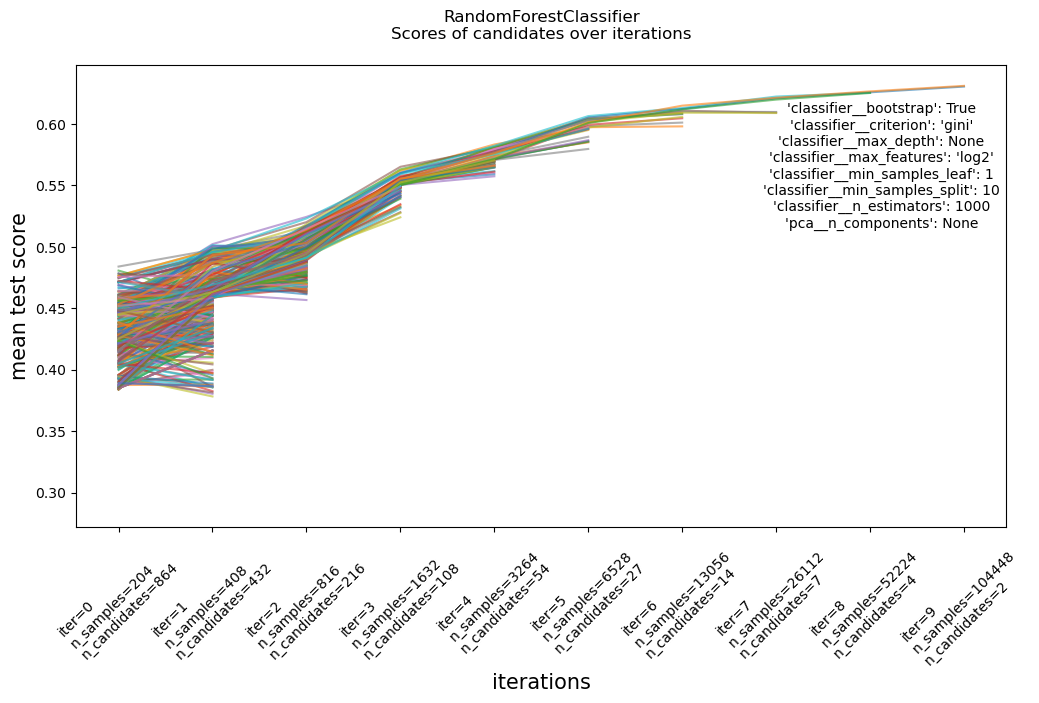

In [54]:
# Plot the scores of candidates over iteraions
def plot_scores(halving_search_model):
    model_name = halving_search_model.estimator.named_steps['classifier'].__class__.__name__

    results = pd.DataFrame(halving_search_model.cv_results_)
    results['params_str'] = results.params.apply(str)
    results.drop_duplicates(subset=('params_str', 'iter'), inplace=True)

    mean_scores = results.pivot(index='iter', columns='params_str', values='mean_test_score')

    ax = mean_scores.plot(legend=False, alpha=0.6, figsize=(12, 6))

    labels = [
        f"iter={i}\nn_samples={halving_search_model.n_resources_[i]}\nn_candidates={halving_search_model.n_candidates_[i]}"
        for i in range(halving_search_model.n_iterations_)
    ]

    ax.set_xticks(range(halving_search_model.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title(f"{model_name}\nScores of candidates over iterations\n")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)

    max_score = mean_scores.max().max()
    max_params_str = mean_scores.columns[(mean_scores == max_score).any()].tolist()[0]

    # Annotate the highest mean test score
    ax.annotate('\n'.join(max_params_str.strip('{').strip('}').split(', ')), xy=(7.9, max_score-0.03), xytext=(15, 15), 
                textcoords='offset points', ha='center', va='top',)
                #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),)
                #arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    #plt.tight_layout()
    plt.show()


plot_scores(halving_search)

## 4 - Load and prepare the test dataset

### 4.1 - Load the test dataset

In [3]:
procd_test_path = os.path.join(processed_data_path, 'procd_test.parquet')

if os.path.exists(procd_test_path):
    procd_test = pd.read_parquet(procd_test_path)
else:
    # Load the test dataset
    test_df = pd.read_parquet(os.path.join(cleaned_data_path, 'test.parquet'))

    procd_test = prepare_data(test_df, 'test', features, rfv_df, icd9cm_df, icd9cm_category, figure_path)
    procd_test.to_parquet(procd_test_path)

In [4]:
# Define the X_test and y_test
X_test = procd_test.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_test.shape}')

y_test = procd_test['DIAG1_CAT'].copy()
print(f'y Shape: {y_test.shape}')

X Shape: (26719, 58)
y Shape: (26719,)


### 4.2 - Check the topic and the label distributions

In [21]:
def prepared_data_from_dict(vis_data):
    # Code adapted from https://github.com/bmabey/pyLDAvis/issues/134
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)


# Load and display the pyLDAvis from saved json file
with open(os.path.join(report_path, 'test_lda_vis.json'), 'r') as f:
    lda_vis = json.load(f)

# Display the pyLDAvis from saved json file
prepared_data = prepared_data_from_dict(lda_vis)
pyLDAvis.display(prepared_data)

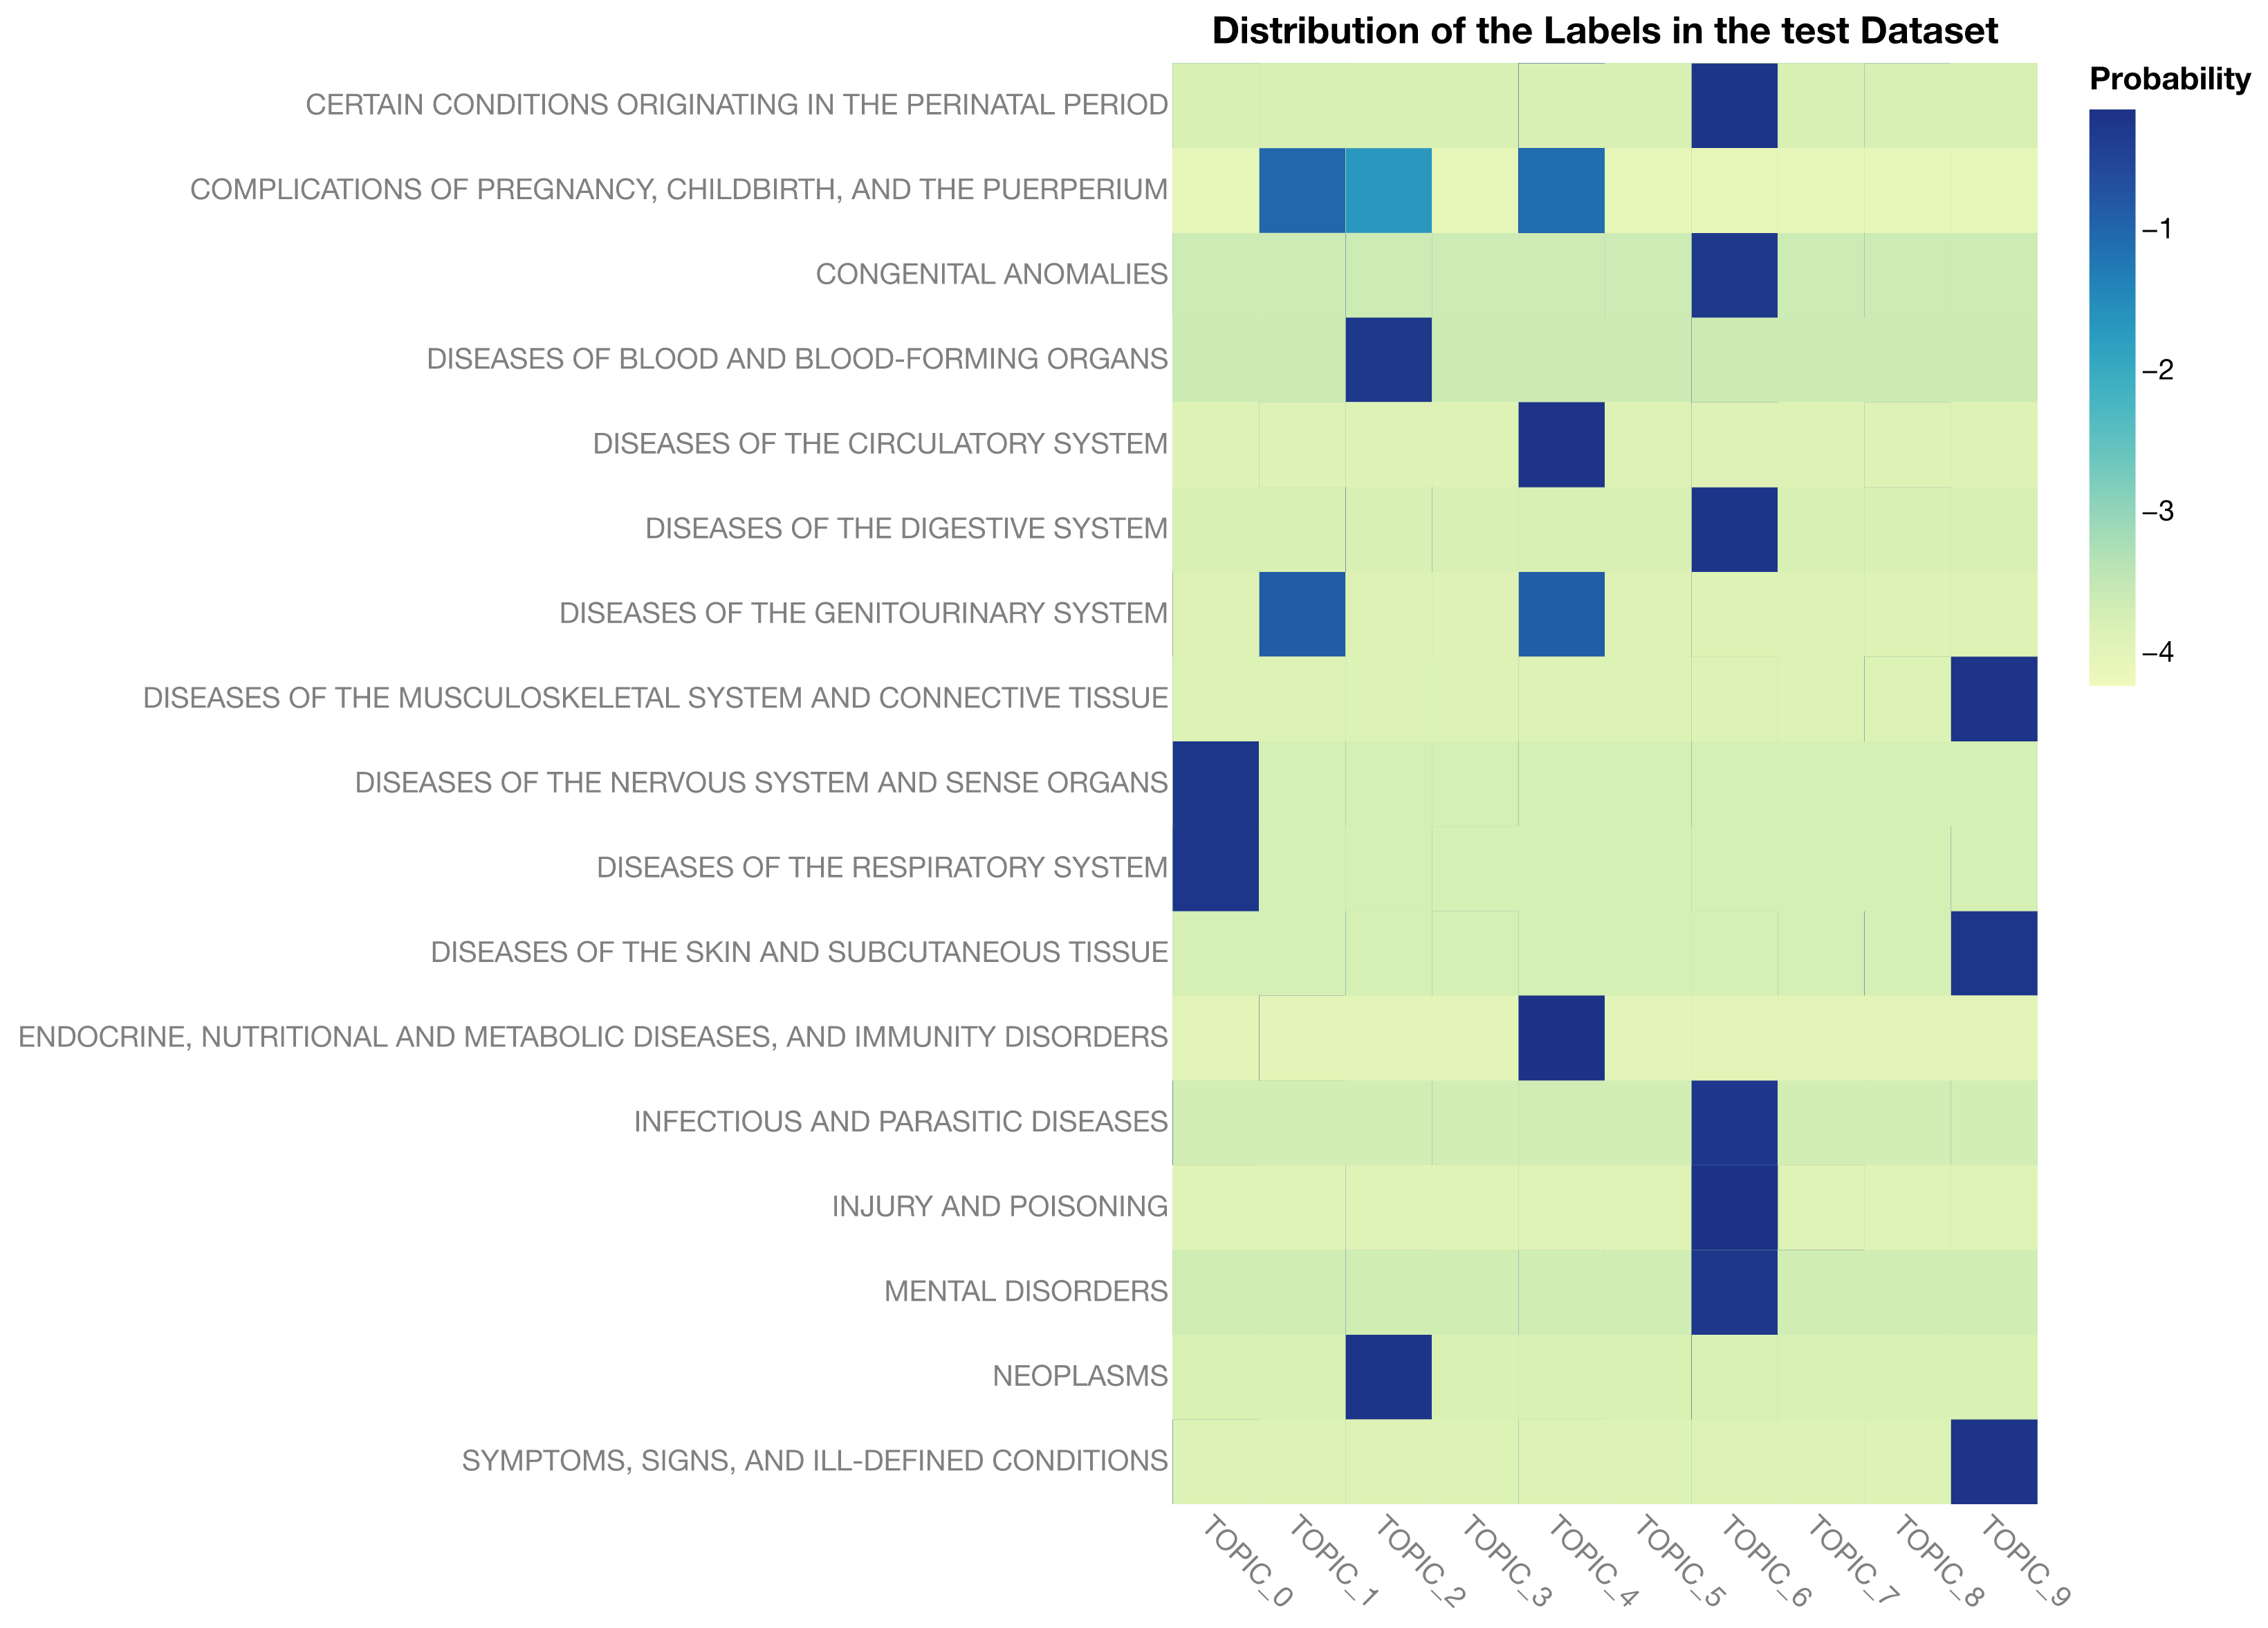

In [22]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'test_topic_distribution_heatmap.png'))

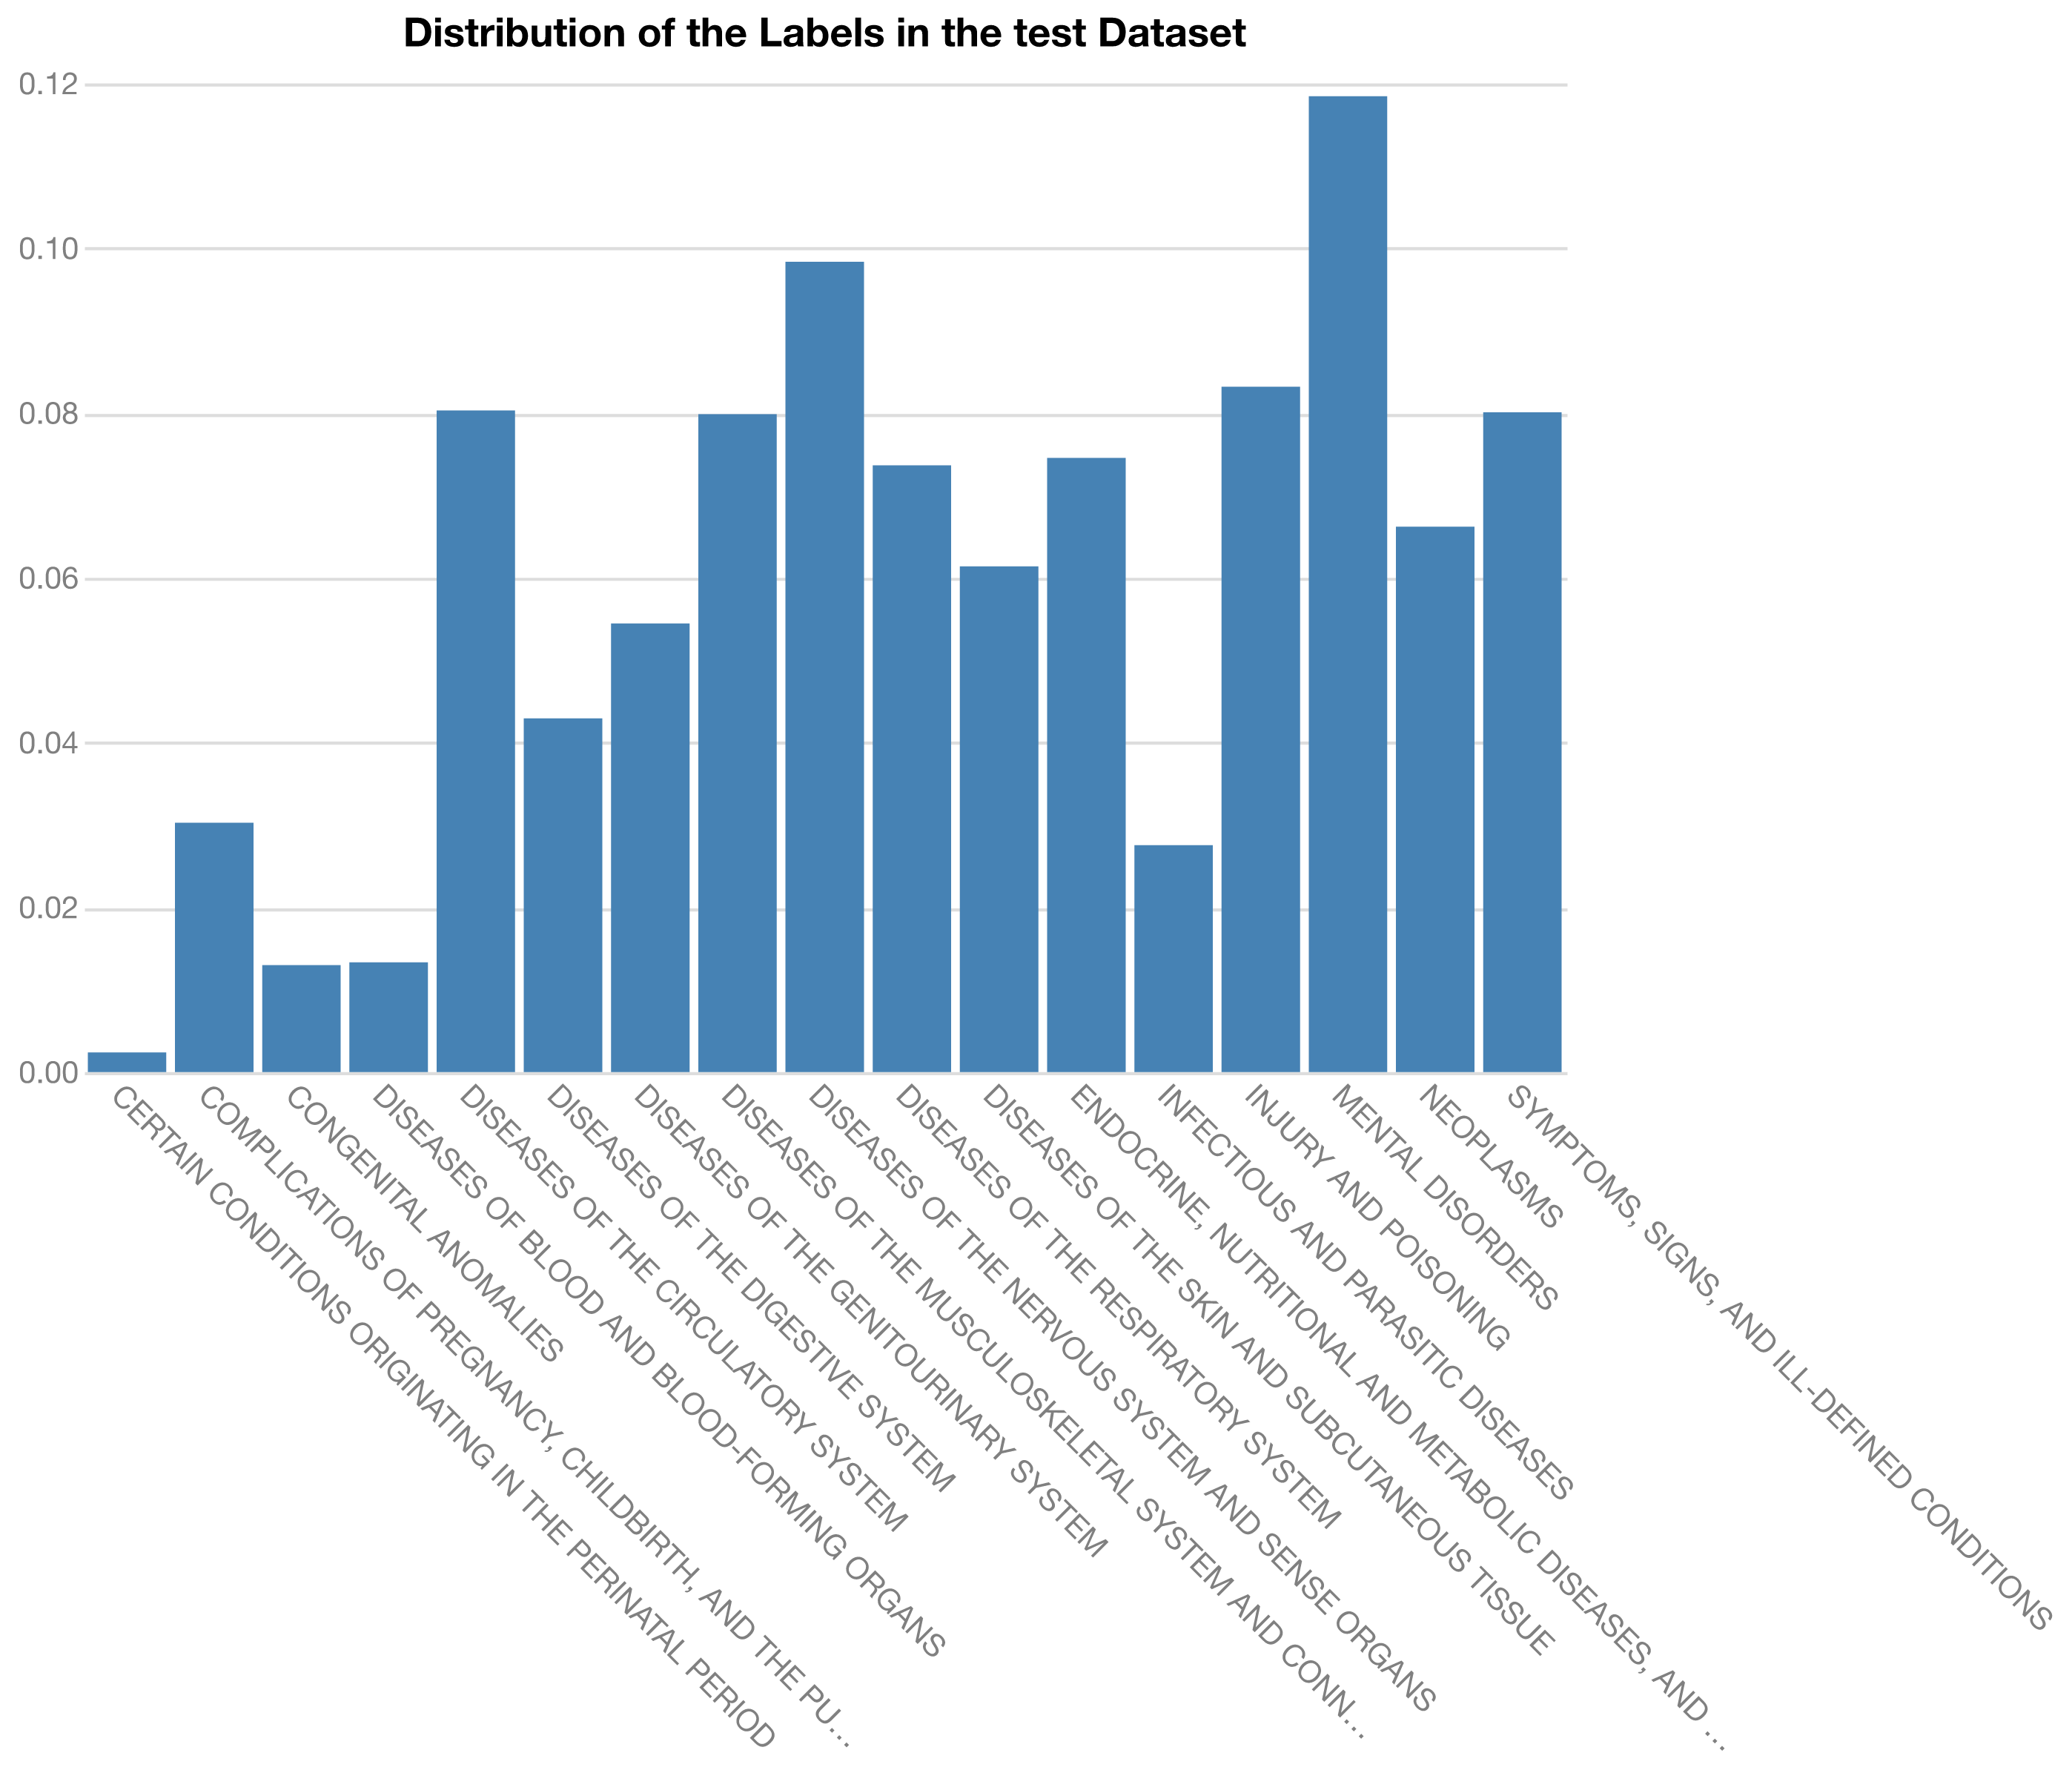

In [23]:
# Load and display the distribution and percentage of the labels
from IPython.display import display
display(Image(filename=os.path.join(figure_path, 'test_label_distribution.png')))

## 5 - Evaluate the best model with the test dataset

In [24]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

### 5.1 - Reload the saved model

In [29]:
# Load the saved model
halving_search = joblib.load(os.path.join(model_path, f'RandomForestClassifier_halving_search_model.joblib'))

### 5.2 - Prediction and Metrics

In [38]:
y_pred = halving_search.predict(X_test)

c:\Users\sean7x\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be remo

In [39]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_test_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.6472217391018723


In [40]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_test[y_test.notna()], y_pred[y_test.notna()]))

Prediction Accuracy: 0.6251730977955762
Weighted Prediction F1 Score: 0.6114770372372604
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.21      0.67      0.32        64
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.76      0.87      0.81       809
                                                 CONGENITAL ANOMALIES       0.31      0.41      0.35       347
                           DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.47      0.30      0.37       356
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.54      0.55      0.55      2146
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.50      0.56      0.53      1147
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.55      0.63      0.58      1455
         DISEASES OF T

### 5.3 - Confusion matrix

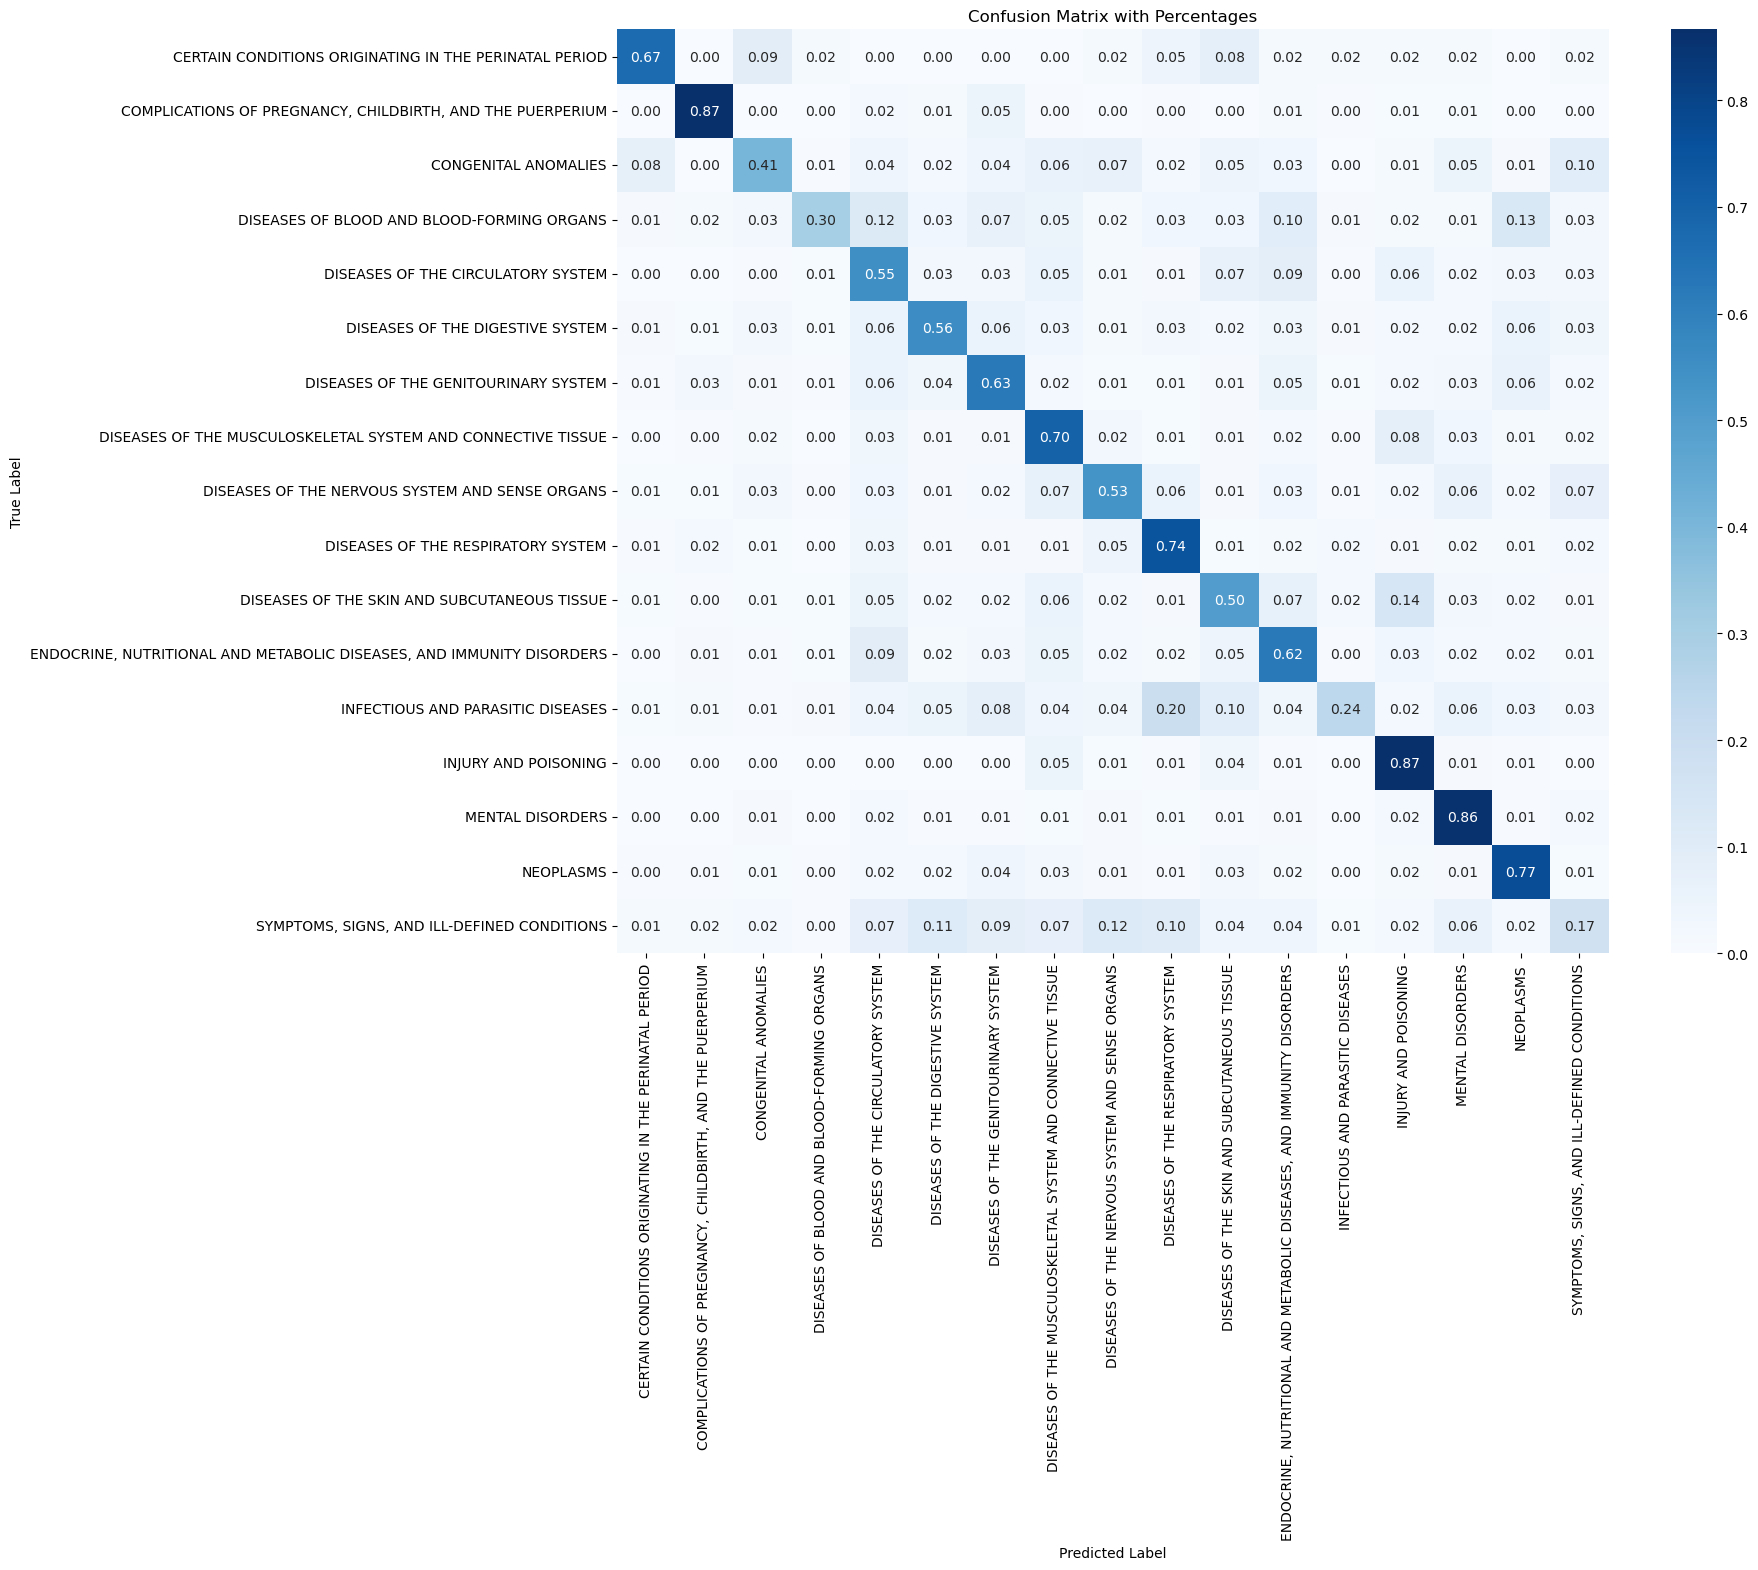

In [41]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=halving_search.classes_, yticklabels=halving_search.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()